In [1]:
import intake
from easygems import healpix as egh
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import healpy as hp
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import numpy.linalg as la

In [3]:
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")["online"]
ds = cat['um_glm_n2560_RAL3p3'](zoom=2).to_dask().sel(time=slice('2020-03-01T00:00:00','2021-03-01T00:00:00'))[['uas','vas', 'sftlf']] #
ds_winds = ds.groupby('time.hour').mean()
ds_winds = ds_winds.assign(ws = np.sqrt(ds_winds.uas**2 + ds_winds.vas**2))

/opt/anaconda3/envs/healpix-cookbook-dev/lib/python3.13/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<Figure size 640x480 with 0 Axes>

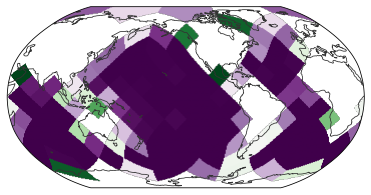

In [3]:
egh.healpix_show(ds_winds["sftlf"].sel(hour = 0), cmap = "PRGn", dpi=72)

IndexError: tuple index out of range

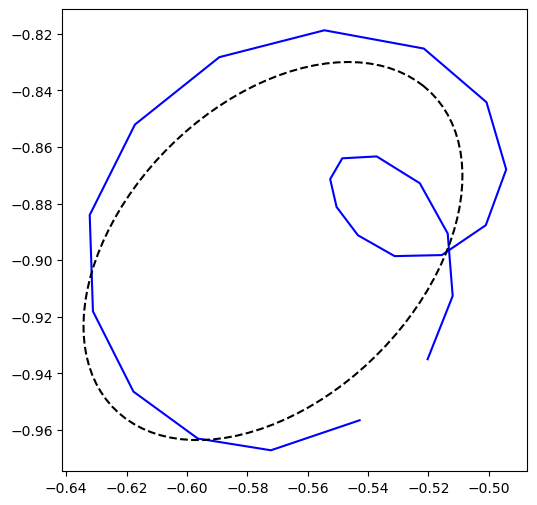

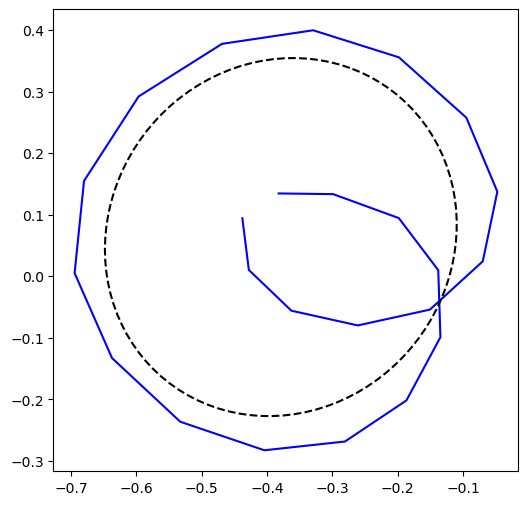

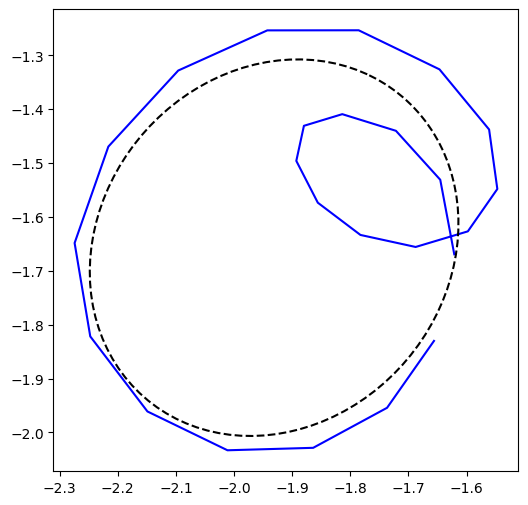

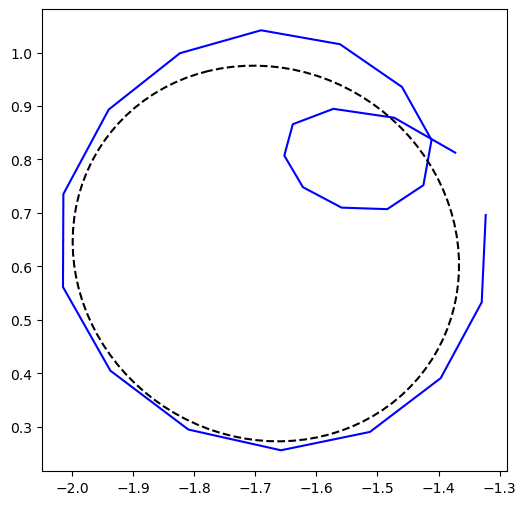

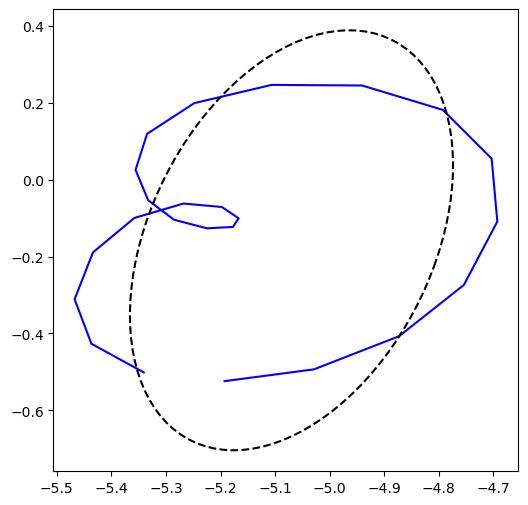

In [ ]:
for cl in range(0,100,5):
    if np.isnan(ds_winds.isel(cell=cl).uas).all() == False:
        x_ds = ds_winds.isel(cell=cl).uas.to_numpy()
        y_ds = ds_winds.isel(cell=cl).vas.to_numpy()

        points = np.array(list(zip(x_ds[::2], y_ds[::2])))
        center, width, height, phi = ellipse_fit(points)
        u0, v0 = center
        u1 = width * np.cos(phi)
        u2 = -height * np.sin(phi)
        v1 = width * np.sin(phi)
        v2 = height * np.cos(phi)
        t = np.linspace(0, 2 * np.pi, 100)
        uelip = u0 + u1 * np.cos(t) + u2 * np.sin(t)
        velip = v0 + v1 * np.cos(t) + v2 * np.sin(t)


        plt.figure(figsize=(6,6))
        plt.plot(x_ds, y_ds, c='b')
        plt.plot(uelip,velip, color="k", ls="--")

In [4]:
def get_nn_lon_lat_index(nside, lons, lats):
    """
    Interpolate from healpix to regular lat lon
    
    nside: integer, power of 2. The return of hp.get_nside()
    lons: uniques values of longitudes
    lats: uniques values of latitudes
    returns: array with the HEALPix cells that are closest to the lon/lat grid
    """
    lons2, lats2 = np.meshgrid(lons, lats)
    return xr.DataArray(
        hp.ang2pix(nside, lons2, lats2, nest = True, lonlat = True),
        coords=[("lat", lats), ("lon", lons)],
    )


In [5]:
#Get the "nside", which is used for regridding
nside = hp.get_nside(ds_winds.uas)

#Set up target latitude and longitude (regular grid) to interpolate onto
target_lats = np.linspace(
    -90,
    90,
    20
)
target_lons = np.linspace(
    0,
    360,
    20
)

target_inds = get_nn_lon_lat_index(nside, target_lons, target_lats)

ds_latlon = ds_winds.isel(cell=target_inds)

In [ ]:
def ellipse_fit(X):
        """ FROM Ben Hammel, & Nick Sullivan-Molina. (2020, March 21). 
        bdhammel/least-squares-ellipse-fitting: v2.0.0 (Version v2.0.0). 
        Zenodo. http://doi.org/10.5281/zenodo.3723294 """
        
        """Fit the data

        Parameters
        ----------
        X : array, shape (n_points, 2)
            Data values for the x-y data pairs to fit

        Returns
        -------
        self : returns an instance of self.
        """

        # extract x-y pairs
        x, y = X.T

        # Quadratic part of design matrix [eqn. 15] from (*)
        D1 = np.vstack([x**2, x*y, y**2]).T
        # Linear part of design matrix [eqn. 16] from (*)
        D2 = np.vstack([x, y, np.ones_like(x)]).T

        # Forming scatter matrix [eqn. 17] from (*)
        S1 = D1.T @ D1
        S2 = D1.T @ D2
        S3 = D2.T @ D2

        # Constraint matrix [eqn. 18]
        C1 = np.array([[0., 0., 2.], [0., -1., 0.], [2., 0., 0.]])

        # Reduced scatter matrix [eqn. 29]
        M = la.inv(C1) @ (S1 - S2 @ la.inv(S3) @ S2.T)

        # M*|a b c >=l|a b c >. Find eigenvalues and eigenvectors from this
        # equation [eqn. 28]
        eigval, eigvec = np.linalg.eig(M)

        # Eigenvector must meet constraint 4ac - b^2 to be valid.
        cond = 4*np.multiply(eigvec[0, :], eigvec[2, :]) - np.power(eigvec[1, :], 2)
        a1 = eigvec[:, np.nonzero(cond > 0)[0]]

        # |d f g> = -S3^(-1) * S2^(T)*|a b c> [eqn. 24]
        a2 = la.inv(-S3) @ S2.T @ a1

        # Eigenvectors |a b c d f g>
        # list of the coefficients describing an ellipse [a,b,c,d,e,f]
        # corresponding to ax**2 + bxy + cy**2 + dx + ey + f from (*)
        #self.coef_ = np.vstack([a1, a2])

        """Returns the definition of the fitted ellipse as localized parameters

        Returns
        _______
        center : tuple
            (x0, y0)
        width : float
            Total length (diameter) of horizontal axis.
        height : float
            Total length (diameter) of vertical axis.
        phi : float
            The counterclockwise angle [radians] of rotation from the x-axis to the semimajor axis
        """

        # Eigenvectors are the coefficients of an ellipse in general form
        # the division by 2 is required to account for a slight difference in
        # the equations between (*) and (**)
        # a*x^2 +   b*x*y + c*y^2 +   d*x +   e*y + f = 0  (*)  Eqn 1
        # a*x^2 + 2*b*x*y + c*y^2 + 2*d*x + 2*f*y + g = 0  (**) Eqn 15
        # We'll use (**) to follow their documentation
        a = np.vstack([a1,a2])[0]
        b = np.vstack([a1,a2])[1] / 2.
        c = np.vstack([a1,a2])[2]
        d = np.vstack([a1,a2])[3] / 2.
        f = np.vstack([a1,a2])[4] / 2.
        g = np.vstack([a1,a2])[5]

        # Finding center of ellipse [eqn.19 and 20] from (**)
        x0 = (c*d - b*f) / (b**2 - a*c)
        y0 = (a*f - b*d) / (b**2 - a*c)
        center = (x0, y0)

        # Find the semi-axes lengths [eqn. 21 and 22] from (**)
        numerator = 2 * (a*f**2 + c*d**2 + g*b**2 - 2*b*d*f - a*c*g)
        denominator1 = (b**2 - a*c) * ( np.sqrt((a-c)**2+4*b**2) - (c+a))  # noqa: E201
        denominator2 = (b**2 - a*c) * (-np.sqrt((a-c)**2+4*b**2) - (c+a))
        height = np.sqrt(numerator / denominator1)
        width = np.sqrt(numerator / denominator2)

        # Angle of counterclockwise rotation of major-axis of ellipse to x-axis
        # [eqn. 23] from (**)
        # w/ trig identity eqn 9 form (***)
        if b == 0 and a > c:
            phi = 0.0
        elif b == 0 and a < c:
            phi = np.pi/2
        elif b != 0 and a > c:
            phi = 0.5 * np.arctan(2*b/(a-c))
        elif b != 0 and a < c:
            phi = 0.5 * (np.pi + np.arctan(2*b/(a-c)))
        elif a == c:
            logger.warning("Ellipse is a perfect circle, the answer is degenerate")
            phi = 0.0
        else:
            raise RuntimeError("Unreachable")

        return center, width, height, phi

0.0 -71.05263157894737
18.94736842105263 -71.05263157894737
56.84210526315789 -71.05263157894737
75.78947368421052 -71.05263157894737
94.73684210526315 -71.05263157894737
113.68421052631578 -71.05263157894737
284.2105263157895 -71.05263157894737
303.1578947368421 -71.05263157894737
341.05263157894734 -71.05263157894737
360.0 -71.05263157894737
18.94736842105263 -61.578947368421055
56.84210526315789 -61.578947368421055
113.68421052631578 -61.578947368421055


/opt/anaconda3/envs/healpix-cookbook-dev/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/healpix-cookbook-dev/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


132.6315789473684 -61.578947368421055
189.4736842105263 -61.578947368421055
303.1578947368421 -61.578947368421055
341.05263157894734 -61.578947368421055


/opt/anaconda3/envs/healpix-cookbook-dev/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/healpix-cookbook-dev/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


132.6315789473684 -52.10526315789474
151.57894736842104 -52.10526315789474
189.4736842105263 -52.10526315789474


/opt/anaconda3/envs/healpix-cookbook-dev/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/healpix-cookbook-dev/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


208.42105263157893 -52.10526315789474
303.1578947368421 -52.10526315789474
341.05263157894734 -52.10526315789474
113.68421052631578 -42.631578947368425
132.6315789473684 -42.631578947368425
151.57894736842104 -42.631578947368425
170.52631578947367 -42.631578947368425
189.4736842105263 -42.631578947368425


/opt/anaconda3/envs/healpix-cookbook-dev/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/healpix-cookbook-dev/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


208.42105263157893 -42.631578947368425
227.36842105263156 -42.631578947368425
246.3157894736842 -42.631578947368425
284.2105263157895 -42.631578947368425
303.1578947368421 -42.631578947368425
322.1052631578947 -42.631578947368425
0.0 -33.15789473684211
18.94736842105263 -33.15789473684211
37.89473684210526 -33.15789473684211
94.73684210526315 -33.15789473684211
113.68421052631578 -33.15789473684211
132.6315789473684 -33.15789473684211
151.57894736842104 -33.15789473684211
170.52631578947367 -33.15789473684211
189.4736842105263 -33.15789473684211
208.42105263157893 -33.15789473684211
227.36842105263156 -33.15789473684211
246.3157894736842 -33.15789473684211
265.2631578947368 -33.15789473684211
284.2105263157895 -33.15789473684211
303.1578947368421 -33.15789473684211
322.1052631578947 -33.15789473684211
341.05263157894734 -33.15789473684211
360.0 -33.15789473684211
0.0 -23.684210526315795
18.94736842105263 -23.684210526315795
37.89473684210526 -23.684210526315795


KeyboardInterrupt: 

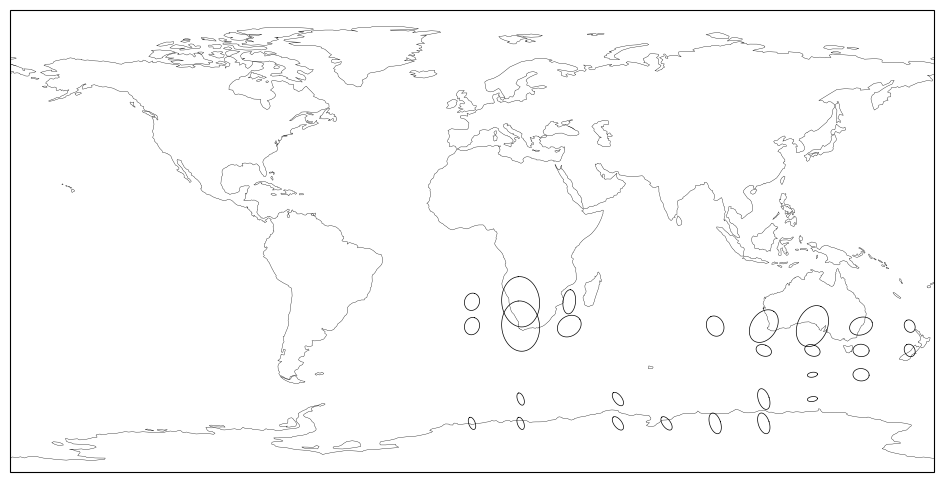

In [7]:
fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines(linewidth=0.25)
#ax.add_feature(cfeature.BORDERS, linewidth=0.5)
#ax.gridlines(draw_labels=True)

for lat in target_lats:
    for lon in target_lons:
        if np.isnan(ds_latlon.sel(lat=lat,lon=lon).uas).all() == False:
            x_ds = ds_latlon.sel(lat=lat,lon=lon).uas.to_numpy()
            y_ds = ds_latlon.sel(lat=lat,lon=lon).vas.to_numpy()
            points = np.array(list(zip(x_ds[::2], y_ds[::2])))
            try:
                center, width, height, phi = ellipse_fit(points)
                u0, v0 = (0,0)

                u1 = width * np.cos(phi)
                u2 = -height * np.sin(phi)
                v1 = width * np.sin(phi)
                v2 = height * np.cos(phi)

                t = np.linspace(0, 2 * np.pi, 100)
                uelip = (u0 + u1 * np.cos(t) + u2 * np.sin(t))
                velip = (v0 + v1 * np.cos(t) + v2 * np.sin(t))
                
                #plt.plot(x_ds, y_ds, c='b')
                ax.plot((uelip*10)+lon,(velip*10)+lat, color="k", linewidth=0.5)
                print(lon, lat)
            except:
                continue